<a href="https://colab.research.google.com/github/leonardoLavagna/TCGA-PRAD/blob/main/DEPM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEPM First Project 
# Prostate Adenocarcinoma TCGA-PRAD  



## PART I DATA 
### Installation of the required libraries and set up

In [ ]:
# Execute the following cell if and only if the bioconductor packages neede for this part are not installed. 
# The installation can take some time (in the order of minutes). 
# See https://bioconductor.org for more details. 

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("TCGAbiolinks")
BiocManager::install("SummarizedExperiment")

In [ ]:
# Libraries for data extraction

library(TCGAbiolinks)
library(SummarizedExperiment)

In [6]:
# Directory tree set up

proj <- "TCGA-PRAD"
dir.create(file.path(proj))

### Getting the Data 
For references, see https://portal.gdc.cancer.gov/projects/TCGA-PRAD.

In [ ]:
# Extract primary tumor data

rna.query.C <- GDCquery(project = proj, data.category = "Transcriptome Profiling", data.type = "Gene Expression Quantification", workflow.type = "STAR - Counts", sample.type = "Primary Tumor") # sample = 01 - TP
GDCdownload(query = rna.query.C, directory = "GDCdata", method = "api")
rna.data.C <- GDCprepare(rna.query.C)
rna.expr.data.C <- assay(rna.data.C)
rna.genes.info.C <- rowRanges(rna.data.C)
rna.sample.info.C <- colData(rna.data.C)
write.table(rna.expr.data.C, file=file.path(proj,paste(proj, "_rna_expr_data_C.txt",sep = "")), row.names=TRUE, col.names=TRUE, quote = FALSE)
write.table(rna.sample.info.C@listData$patient, file=file.path(proj,paste(proj, "_rna_patients_C.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)
write.table(rna.genes.info.C@ranges@NAMES, file=file.path(proj,paste(proj, "_rna_genes_C.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)


In [ ]:
# Extract solid tissue normal data

rna.query.N <- GDCquery(project = proj, data.category = "Transcriptome Profiling", data.type = "Gene Expression Quantification", workflow.type = "STAR - Counts", sample.type = "Solid Tissue Normal") 
GDCdownload(query = rna.query.N, directory = "GDCdata", method = "api")
rna.data.N <- GDCprepare(rna.query.N)
rna.expr.data.N <- assay(rna.data.N)
rna.genes.info.N <- rowRanges(rna.data.N)
rna.sample.info.N <- colData(rna.data.N)
write.table(rna.expr.data.N, file=file.path(proj,paste(proj, "_rna_expr_data_N.txt",sep="")), row.names=TRUE, col.names=TRUE, quote = FALSE)
write.table(rna.sample.info.N@listData$patient, file=file.path(proj,paste(proj, "_rna_patients_N.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)
write.table(rna.genes.info.N@ranges@NAMES, file=file.path(proj,paste(proj, "_rna_genes_N.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)


In [ ]:
# Extra Information from the patients useful for future analysis
# clinical.query<-GDCquery_clinic(project = proj, type = "clinical", save.csv = FALSE)
# write.csv(clinical.query, file = file.path(proj,paste(proj, "_clinical_data.txt",sep="")), row.names = FALSE, quote = FALSE)



### Processing the extracted data

#### 1) read the condition (tumor) TCGA-PRAD dataset

In [15]:
rna_expr_data_C <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_expr_data_C.txt", header=TRUE, sep="", check.names = F) 
# View(rna_expr_data_C)

In [18]:
rna_gene_data_C <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_genes_C.txt", header=FALSE, sep="", check.names = F) 
# View(rna_gene_data_C)

In [20]:
rna_patients_data_C <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_patients_C.txt", header=FALSE, sep="", check.names = F) 
# View(rna_patients_data_C)

#### 2) read the normal (natural) TCGA-PRAD dataset

In [23]:
rna_expr_data_N <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_expr_data_N.txt", header=TRUE, sep="", check.names = F) 
# View(rna_expr_data_N)

In [24]:
rna_gene_data_N <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_genes_N.txt", header=FALSE, sep="", check.names = F) 
# View(rna_gene_data_N)

In [25]:
rna_patients_data_N <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_patients_N.txt", header=FALSE, sep="", check.names = F) 
# View(rna_patients_data_N)

In [ ]:
# Extra Information from the patients useful for future analysis

# clinical_data <- read.csv2("./TCGA-PRAD/TCGA-PRAD_clinical_data.txt", header = FALSE, sep=",")
# colnames(clinical_data) <- clinical_data[1,]; clinical_data <- clinical_data[-1,] 
# View(clinical_data)

#### 3) Intersection and cleaning of partecipants' data

In [ ]:
# Libraries for merging and cleaning the data

library(dplyr)
library(stringr)

In [27]:
# merge common patients

common_patients <- merge(rna_patients_data_C, rna_patients_data_N, by.x="V1", by.y="V1")

In [31]:
# subtract useless column between the two expression data.frames using a boolean mask
# check for multiple patterns and use the boolean mask created to filter through the columns

mask_tuned_patientsC <- str_detect(as.vector(colnames(rna_expr_data_C)), paste(as.vector(unlist(common_patients)), collapse = '|'))
rna_expr_data_C <- rna_expr_data_C[, mask_tuned_patientsC]

mask_tuned_patientsN <- str_detect(as.vector(colnames(rna_expr_data_N)), paste(as.vector(unlist(common_patients)), collapse = '|')) 
rna_expr_data_N <- rna_expr_data_N[, mask_tuned_patientsN] 

In [33]:
# cleaning the rows with any zero values through each of the two data.frames

rna_expr_data_C <- rna_expr_data_C[apply(rna_expr_data_C, 1, function(x) all(x!=0)),]
rna_expr_data_N <- rna_expr_data_N[apply(rna_expr_data_N, 1, function(x) all(x!=0)),]

In [34]:
# row-wise intersection (genes) of the two data.frames

rna_expr_data_C <- subset(rna_expr_data_C, rownames(rna_expr_data_C) %in% rownames(rna_expr_data_N))
rna_expr_data_N <- subset(rna_expr_data_N, rownames(rna_expr_data_N) %in% rownames(rna_expr_data_C))


In [36]:
# Verify that all the duplicate partecipants have been removed

# dummy_split <- as.data.frame(t(apply(common_patients, 1, function(k){
# sym <- unlist(strsplit(k, split = "-"))
# return(c(sym[1], sym[2], sym[3]))
# }))); colnames(dummy_split) <- c("A", "B", "C"); dummy_split[duplicated(dummy_split$C),]


## PART II
## Differentially Expressed Genes (DEGs)

### Installation of the required libraries and set up

In [ ]:
# Execute the following cell if and only if the bioconductor packages neede for this part are not installed. 
# The installation can take some time (in the order of minutes). 
# See https://bioconductor.org for more details. 

if (!requireNamespace("BiocManager", quietly = TRUE))
   install.packages("BiocManager")
 
BiocManager::install("DESeq2")

In [38]:
# Library to handle DEGs

library(DESeq2)

### Processing 

#### 1) Merging of the columns

In [39]:
# sort the column names for each dataset before merging them

rna_expr_data_C <- rna_expr_data_C[,order(colnames(rna_expr_data_C))]
rna_expr_data_N <- rna_expr_data_N[,order(colnames(rna_expr_data_N))]

In [40]:
# Rename the columns
addInfoData <- function(dt, info){
  colInfo <- c()

  for(name in colnames(dt)){
    colInfo <- c(colInfo, paste(name, info, sep=""))  
  }
  
  colnames(dt) <- colInfo
  return(dt)
}

rna_expr_data_C <- addInfoData(rna_expr_data_C, "_tumor")
rna_expr_data_N <- addInfoData(rna_expr_data_N, "_normal")


In [43]:
# Merge the columns, sorted and aggregated

full_dt <- cbind(rna_expr_data_N, rna_expr_data_C) 
#View(full_dt)

#### 2) Additional informations

In [44]:
# create a dataset with additional information

PartecipantsCondition <- data.frame(partecipants = colnames(full_dt),
                                    condition = NA) 
PartecipantsCondition <- as.data.frame(t(apply(PartecipantsCondition, 1, function(x){
    if(grepl("tumor", x["partecipants"]))
      return(c(x["partecipants"], condition = "tumor"))
    else
      return(c(x["partecipants"], condition = "normal"))
})));

In [45]:
# creating the Object of our merged matrix to be "DESQued"
DESQ_dt <- DESeqDataSetFromMatrix(countData = full_dt,
                                  colData = PartecipantsCondition,
                                  design= ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


#### 3) Remove the genes where there are very few reads
*Remark:* This processing step will reduce the memory size of the actual dataset, and increase also the future transformation and testing functions.

In [46]:
# Here we perform a minimal pre-filtering to keep only rows that have at least 10 reads total. 
# Note that more strict filtering to increase power is automatically applied via 
# independent filtering on the mean of normalized counts within the results function.
keep <- rowSums(counts(DESQ_dt)) >= 10 # this could be a first threshold for us... more strict less genes
DESQ_dt <- DESQ_dt[keep,]

#### 4) Tresholding
*Remark:* here we get the results, obtaining the correction FDR through different tests Its important to keep track of the adjpvalue

In [47]:
DESQ_dtOutput <- DESeq(DESQ_dt)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 602 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [50]:
# this applies a threshold of alpha = 0.05, to make correction of different tests applied, 
# we apply some corrections optimizing the number of genes which will have an adjusted p value below a given FDR cutoff, 
# alpha = 0.05 and not 0.1
res <- results(DESQ_dtOutput, alpha = 0.05, lfcThreshold = 1.2)  


out of 18271 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.20 (up)    : 49, 0.27%
LFC < -1.20 (down) : 120, 0.66%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



*Remark:* LFC means Log Fold Change. Recall that if LFC > 0 then the number of genes is up-regulated and viceversa (down-regulated < 0).  Moreover LFC > 0 means more expression in NORMAL condition, and LFC < 0  menas is more expression in TUMOR condition.



In [51]:
# Display the summary of the results

summary(res)


out of 18271 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.20 (up)    : 49, 0.27%
LFC < -1.20 (down) : 120, 0.66%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



#### 4) Plots

In [52]:
# differentially expressed gene ordered from the lower at the larger value of adjustedPvalue
resOrdered <- res[order(res$padj), ]

In [53]:
# versus conditions
resultsNames(DESQ_dtOutput)

[1] "Intercept"                 "condition_tumor_vs_normal"

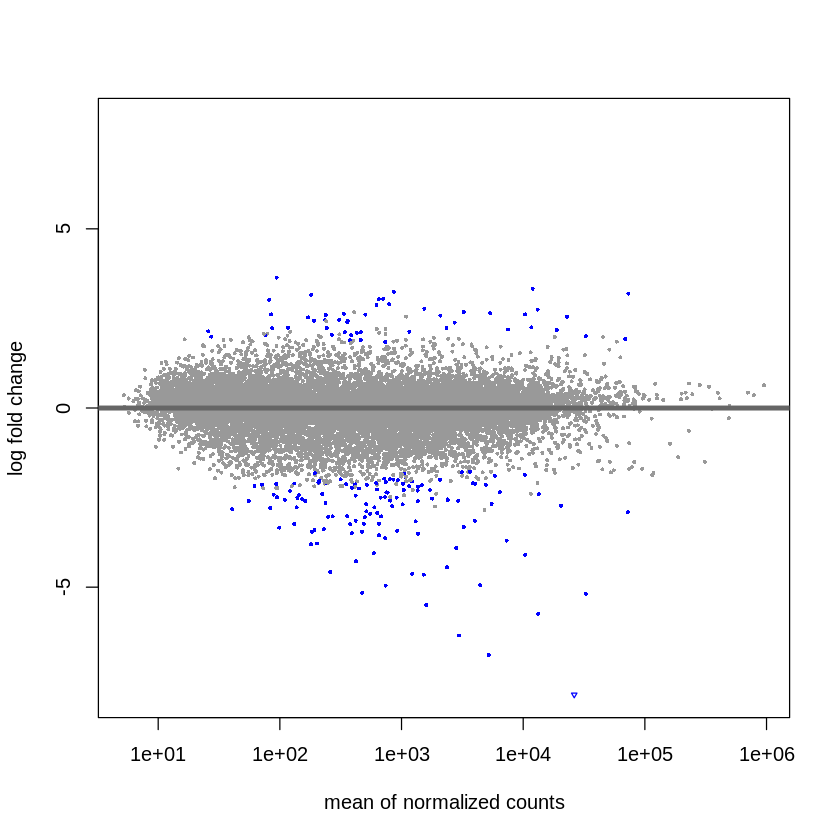

In [54]:
# the function plotMA shows the log2 fold changes attributable to a given variable 
# over the mean of normalized counts for all the samples in the DESeqDataSet. 
# Points will be colored red if the adjusted p value is less than 0.1. 
# Points which fall out of the window are plotted as open triangles pointing either up or down. 
plotMA(res, ylim = c(-8, 8))

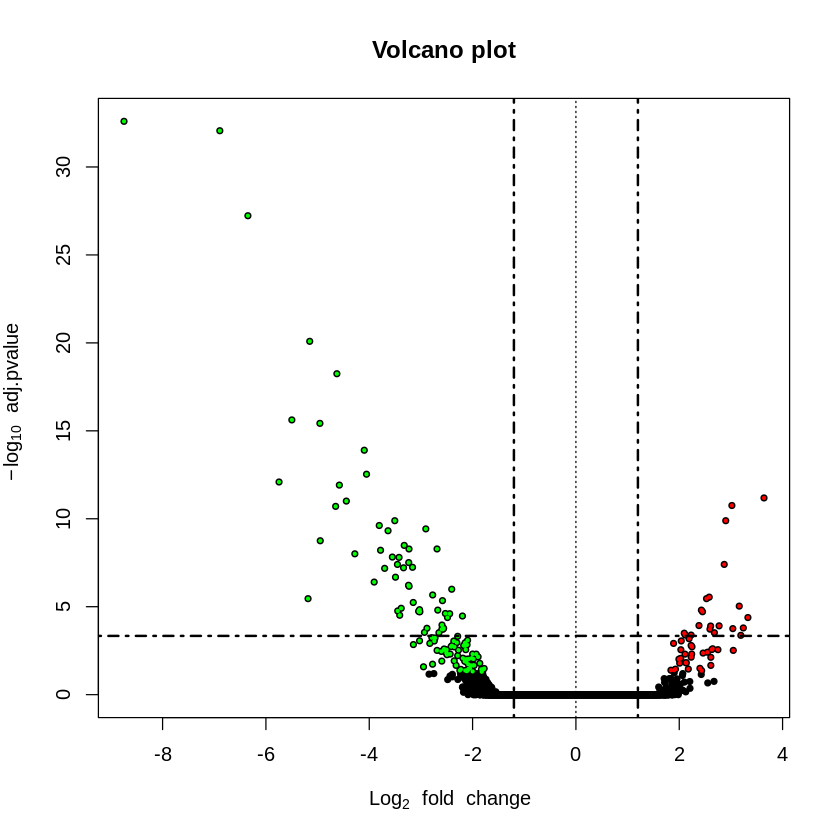

In [55]:
# Volcano Plot

topT <- as.data.frame(res)

#Adjusted P values (FDR Q values)
with(topT, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot", cex=1.0, xlab=bquote(~Log[2]~fold~change), ylab=bquote(~-log[10]~adj.pvalue)))
with(subset(topT, padj<=0.05 & log2FoldChange>=1.2), points(log2FoldChange, -log10(padj), pch=20, col="red", cex=0.5))
with(subset(topT, padj<=0.05 & log2FoldChange<= -1.2), points(log2FoldChange, -log10(padj), pch=20, col="green", cex=0.5))

#Add lines for absolute FC>2 and P-value cut-off at FDR Q<0.05
abline(v=0, col="black", lty=3, lwd=1.0)
abline(v=-1.2, col="black", lty=4, lwd=2.0)
abline(v=1.2, col="black", lty=4, lwd=2.0)
abline(h=-log10(max(topT$pvalue[topT$padj<=0.05], na.rm=TRUE)), col="black", lty=4, lwd=2.0)
